What is an accurate distance to assess similarities and differences between objects
- characterized by categorical variables
- and with a very sparse dataset?



In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
from sklearn.neighbors import NearestNeighbors

In [10]:
df_cat = pd.DataFrame({'Color':['Blue', 'Blue', 'Red', 'Yellow'],
                       'Shape': ['Square', 'Square', 'Circle', 'Circle']})
df_bin = pd.get_dummies(df_cat)
display(df_cat)
display(df_bin)

,Color,Shape
0,Blue,Square
1,Blue,Square
2,Red,Circle
3,Yellow,Circle


,Color_Blue,Color_Red,Color_Yellow,Shape_Circle,Shape_Square
0,1,0,0,0,1
1,1,0,0,0,1
2,0,1,0,1,0
3,0,0,1,1,0


We end up with as many columns as modalities of the variables

But the modalities of the variables could be not mutually exclusive: eg the first object could be a square with blue AND red

In [11]:
df_bin2 = df_bin.copy()
df_bin2.iloc[0,1] = 1
display(df_bin2)

,Color_Blue,Color_Red,Color_Yellow,Shape_Circle,Shape_Square
0,1,1,0,0,1
1,1,0,0,0,1
2,0,1,0,1,0
3,0,0,1,1,0


if we add variables we will obtain a dataset with a growing number of columns filled by "1" and mostly by "0": a sparse dataset

# 1. Euclidean distances

In [12]:
df_test = pd.DataFrame({'A':[1,1,1,1,1], 'B':[1,1,0,1,1],'C':[1,0,0,1,1],
                         'D':[0,0,0,1,1],'E':[0,0,0,0,1],'F':[0,0,0,0,1]})
display(df_test)

,A,B,C,D,E,F
0,1,1,1,0,0,0
1,1,1,0,0,0,0
2,1,0,0,0,0,0
3,1,1,1,1,0,0
4,1,1,1,1,1,1


Let's say we want to compare every object to the target object 'ABC' in line 0
We will use NearestNeighbors function to quickly compute euclidean distances

In [13]:
from sklearn.neighbors import NearestNeighbors
NN1 = NearestNeighbors(n_neighbors=5, algorithmfrom sklearn.neighbors import NearestNeighbors='auto', metric='euclidean')
NN1.fit(df_test)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [14]:
NN1.kneighbors([np.array(df_test.iloc[0])], return_distance=True)

(array([[0.        , 1.        , 1.        , 1.41421356, 1.73205081]]),
 array([[0, 1, 3, 2, 4]], dtype=int64))

Objects 1 'AB' and 3 'ABCD' are the closest to the object 0 'ABC' with a distance of 1 for both object although object 3 shares 3 values 'ABC' with the target

The reason is that when computing euclidean distances both (1,1) and (0,0) couples are considered like similarities and simply put euclidean distance will rely only true differences: (0,1) or (1,0) wit d = sqrt(nb true differences)

Does sharing the absence of a characteristic bring the same value as sharing the presence of a characteristic?

In [15]:
df_test2 = pd.DataFrame({'Blue':[1,0,1], 'Red':[1,0,0],'Yellow':[0,0,1]})
display(df_test2)

,Blue,Red,Yellow
0,1,1,0
1,0,0,0
2,1,0,1


In [16]:
NN1 = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='euclidean')
NN1.fit(df_test2)
NN1.kneighbors([np.array(df_test2.iloc[0])], return_distance=True)

(array([[0.        , 1.41421356, 1.41421356]]),
 array([[0, 1, 2]], dtype=int64))

Here the object 1 that shares no color with the target is considered as similar to the target than the object 2 that shares the color blue with the target
(but object 1 must have a color, maybe that's just due to a lack of information?)

In [17]:
df_test3 = pd.DataFrame({'Blue':[1,0,1,1], 'Red':[1,0,0,0],'Yellow':[0,1,1,1], 'Green': [0,0,0,1]})
display(df_test3)

,Blue,Green,Red,Yellow
0,1,0,1,0
1,0,0,0,1
2,1,0,0,1
3,1,1,0,1


In [18]:
NN1 = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NN1.fit(df_test3)
NN1.kneighbors([np.array(df_test3.iloc[0])], return_distance=True)

(array([[0.        , 1.41421356, 1.73205081, 1.73205081]]),
 array([[0, 2, 1, 3]], dtype=int64))

Here the object 1 that shares no color with the target is considered as similar to the target than the object 3 that shares the color blue with the target... because both object have the same numbers of true differences 

Here we'd like to compare 4 objects based on their colors. What happens if we use euclidean distances to look for similarities among our objects?

The target object is blue and red

The object 1 that shares no color with the target is considered as similar to the target than the object 3 that shares the color blue with the target but is also green... 

In our case, we'd rather say than the blue-green object is more similar to the blue-red object than the yellow object!

 With euclidean distances both double-presence (like blue for objects 0 and 3) and double-absence (like green for objects 0 and 1) count for a similarity.
Only presence vs absence cases are counted as true differences and the euclidean distane is the square root of the number of true differences.


# 2. Distance of Jaccard and data normalization

In [20]:
NN2 = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='jaccard')
NN2.fit(df_test3)
NN2.kneighbors([np.array(df_test3.iloc[0])], return_distance=True)

C:\Users\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


(array([[0.        , 0.66666667, 0.75      , 1.        ]]),
 array([[0, 2, 3, 1]], dtype=int64))

Jaccard gives the ratio of shared elements on the set of elements present in either of the two objects
That's the intersection set on the union set
Object 0 has 'blue', 'red'
object 2 has 'blue', 'yellow'
thus
the union set is 'blue', 'red', 'yellow' = 3 elements
the intersection set is 'blue' = 1 element
and
Jaccard similarity index is 1/3
and Jaccard distance is 1 - 1/3 = 2/3

In [21]:
def df_normalization(df):
    norm_df = df.mul(df).sum(axis=1)
    return df.mul(1/np.sqrt(norm_df),axis=0)

In [22]:
df_test3_normed = df_normalization(df_test3)
NN2 = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NN2.fit(df_test3_normed)
NN2.kneighbors([np.array(df_test3_normed.iloc[0])], return_distance=True)

(array([[0.        , 1.        , 1.08788943, 1.41421356]]),
 array([[0, 2, 3, 1]], dtype=int64))

Normalizing the data before calculating Euclidean distances is a way to obtain a result similar to Jaccard's distance: The double-absences aren't considered in the distance computation

In [25]:
df_bin_normed

,Color_Blue,Color_Red,Color_Yellow,Shape_Circle,Shape_Square
0,0.707107,0.000000,0.000000,0.000000,0.707107
1,0.000000,0.707107,0.000000,0.000000,0.707107
2,0.707107,0.000000,0.000000,0.707107,0.000000
3,0.000000,0.000000,0.707107,0.707107,0.000000


In [26]:
df_bin_normed.sum(axis=0)

Color_Blue      1.414214
Color_Red       0.707107
Color_Yellow    0.707107
Shape_Circle    1.414214
Shape_Square    1.414214
dtype: float64

In [27]:
df_bin.sum(axis=0)

Color_Blue      2
Color_Red       1
Color_Yellow    1
Shape_Circle    2
Shape_Square    2
dtype: int64

**Note**: Normalization doesn't modifiy the relative importance of the variables (in term of amount of information).
The normalizing operation is a *'standardization'** process not a *'transformation'* of the data.

# 3. sparse data and low information

In [23]:
df_cat = pd.DataFrame({'Color':['Blue', 'Red', 'Blue', 'Yellow'],
                       'Shape': ['Square', 'Square', 'Circle', 'Circle']})
df_bin = pd.get_dummies(df_cat)
display(df_cat)
display(df_bin)

,Color,Shape
0,Blue,Square
1,Red,Square
2,Blue,Circle
3,Yellow,Circle


,Color_Blue,Color_Red,Color_Yellow,Shape_Circle,Shape_Square
0,1,0,0,0,1
1,0,1,0,0,1
2,1,0,0,1,0
3,0,0,1,1,0


In [24]:
df_bin_normed = df_normalization(df_bin)
NNb = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NNb.fit(df_bin_normed)
NNb.kneighbors([np.array(df_bin_normed.iloc[0])], return_distance=True)

(array([[0.        , 1.        , 1.        , 1.41421356]]),
 array([[0, 1, 2, 3]], dtype=int64))

When few information is available it's easy to run into *ex-aequo* when ranking objects based on their respective distances to the target object.

How could we increase the quantity of information to obtain more variability, more subtleties, among object?

Objects 1 and 2 are both at the same distance of the target and this result appears totally reasonable. 

To gain more precision, ideally we would need to gather more information and add informative variables to the dataset. Otherwise, another solution is to transform the data to bring more variations. Unlike standardization, transformation implies a change of the information of the initial dataset. Such operation must be well argumented.

### Variables weighting

The most straightforward way is to weight some variables relatively to others so that you give them more importance when calculating distances among objects. This way the wole dataset information will be richer and *ex-aequo* will be rarer when looking for nearest neighbors of a target object

#### Note:
This operation transforms the initial data, it's thus critical to have some arguments to defend your choice of transformation

- you could choose the variables to weight based on expert knowledge of which part of information is more important relatively to your question

- you could give more weight to the more 'abundant' variables in the dataset by basing the weighting on the marginal sums of the columns

### 3.1 Expert-based weighting
Based on our knowledge of the problem we could decide similarities on colors are more imprtant than on shape

In [27]:
df_test2.mul([2,2,2,1,1],axis=1)

,Blue,Red,Yellow,Circle,Square
0,2,0,0,0,1
1,0,2,0,0,1
2,2,0,0,1,0
3,0,0,2,1,0


In [28]:
nn_results(df_test2.mul([2,2,2,1,1],axis=1),n_neighbors=4, metric='euclidean');

Nearest neighbors: 
 [[0 2 1 3]]
Distances to target 0: 
 [[0.         1.41421356 2.82842712 3.16227766]]


### 3.2 Weighting based on marginal sum of columns

In [145]:
from utils import col_weighting

In [30]:
print('Frequent variables favored:')
df_test3 = col_weighting(df_test2, fun=lambda x: np.sqrt(x))
display(df_test3)
nn_results(df_normalization(df_test3),n_neighbors=4, metric='euclidean');
print('\n')

print('Rare variables favored:')
df_test3 = col_weighting(df_test2, fun=lambda x: 1/x)
display(df_test3)
nn_results(df_normalization(df_test3),n_neighbors=4, metric='euclidean');

Frequent variables favored:


,Blue,Red,Yellow,Circle,Square
0,1.414214,0.0,0.0,0.000000,1.414214
1,0.000000,1.0,0.0,0.000000,1.414214
2,1.414214,0.0,0.0,1.414214,0.000000
3,0.000000,0.0,1.0,1.414214,0.000000


Nearest neighbors: 
 [[0 1 2 3]]
Distances to target 0: 
 [[0.         0.91940169 1.         1.41421356]]


Rare variables favored:


,Blue,Red,Yellow,Circle,Square
0,0.5,0.0,0.0,0.0,0.5
1,0.0,1.0,0.0,0.0,0.5
2,0.5,0.0,0.0,0.5,0.0
3,0.0,0.0,1.0,0.5,0.0


Nearest neighbors: 
 [[0 2 1 3]]
Distances to target 0: 
 [[0.         1.         1.16942057 1.41421356]]


In [47]:
def col_weighting(df):
    col_marg = df.sum(axis=0)
    return df.mul(col_marg, axis=1)

In [25]:
df_bin2 = col_weighting(df_bin)
display (df_bin2)

,Color_Blue,Color_Red,Color_Yellow,Shape_Circle,Shape_Square
0,2,0,0,0,2
1,0,1,0,0,2
2,2,0,0,2,0
3,0,0,1,2,0


In [26]:
df_bin2_normed = df_normalization(df_bin2)
NNb = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NNb.fit(df_bin2_normed)
NNb.kneighbors([np.array(df_bin2_normed.iloc[0])], return_distance=True)

(array([[0.        , 0.85737328, 1.        , 1.41421356]]),
 array([[0, 1, 2, 3]], dtype=int64))

By weighting variable relatively to the marginal sum of columns we gave more importance to variables 'Blue', 'Circle' and 'Square' over 'red' and 'yellow'.
Consequently object 1 is now closer to object 0: he shares important element with 0 ('Square') while one of his differences is on minor variable ('Red')
conversely object shares one important variable ('Blue') but his two differences are on important variables ('Circle' and 'square'): his distance is now greater

### 3.3 PCA-based weighting

In [31]:
from sklearn import decomposition

In [32]:
pca_bin_part = decomposition.PCA(n_components=2)
pca_bin_part.fit(df_normalization(df_test2))
df_pca_bin_part = pd.DataFrame(pca_bin_part.transform(df_normalization(df_test2)),index= df_test2.index)
display(df_pca_bin_part)
print('explained variance: ',pca_bin_part.explained_variance_ratio_.sum())
nn_results(df_pca_bin_part,n_neighbors=4, metric='euclidean');

,0,1
0,0.425325,-0.433013
1,0.688191,0.433013
2,-0.425325,-0.433013
3,-0.688191,0.433013


explained variance:  0.9151186641666433
Nearest neighbors: 
 [[0 2 1 3]]
Distances to target 0: 
 [[0.         0.85065081 0.9050405  1.41064478]]


### PCA

In [27]:
from sklearn import decomposition

In [30]:
pca_bin_full = decomposition.PCA()
pca_bin_full.fit(df_bin_normed)
df_pca_bin_full = pd.DataFrame(pca_bin_full.transform(df_bin_normed),index= df_bin_normed.index)
display (df_pca_bin_full)
print('explained variance: ',pca_bin_full.explained_variance_ratio_.cumsum())

,0,1,2,3
0,0.425325,-0.433013,-0.262866,-4.597257e-18
1,0.688191,0.433013,0.162460,-1.711307e-16
2,-0.425325,-0.433013,0.262866,3.099086e-16
3,-0.688191,0.433013,-0.162460,-1.480584e-16


explained variance:  [0.58178533 0.91511866 1.         1.        ]


In [32]:
pca_bin_part = decomposition.PCA(n_components=2)
pca_bin_part.fit(df_bin_normed)
df_pca_bin_part = pd.DataFrame(pca_bin_part.transform(df_bin_normed),index= df_bin_normed.index)
display (df_pca_bin_part)
print('explained variance: ',pca_bin_part.explained_variance_ratio_.cumsum())

,0,1
0,0.425325,-0.433013
1,0.688191,0.433013
2,-0.425325,-0.433013
3,-0.688191,0.433013


explained variance:  [0.58178533 0.91511866]


In [33]:
NNp1 = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NNp1.fit(df_pca_bin_full)
NNp1.kneighbors([np.array(df_pca_bin_full.iloc[0])], return_distance=True)

(array([[1.05367121e-08, 1.00000000e+00, 1.00000000e+00, 1.41421356e+00]]),
 array([[0, 2, 1, 3]], dtype=int64))

1 & 2 are still ex-aequo: we haven't modified initial information

In [34]:
NNp2 = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NNp2.fit(df_pca_bin_part)
NNp2.kneighbors([np.array(df_pca_bin_part.iloc[0])], return_distance=True)

(array([[0.        , 0.85065081, 0.9050405 , 1.41064478]]),
 array([[0, 2, 1, 3]], dtype=int64))

1 & 2 aren't ex-aequo anymore
by suppressing a bit of information we have introduced some wieghting and added some variations

the two methods don't give same results: not the same information is favored

Text(0,0.5,'PC 0')

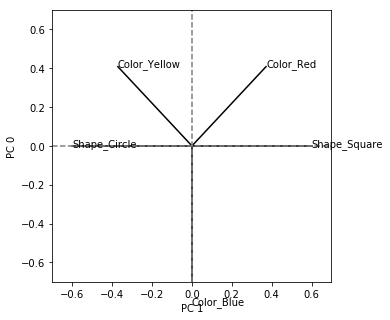

In [42]:
pcs = pca_bin_part.components_
tmp = pd.DataFrame(pcs.T)
p_lab = df_bin.columns#[selec]

fig = plt.figure(figsize=(5,5))

for i, (x,y) in enumerate(zip(pcs[0,:], pcs[1,:])):
    plt.plot([0,x], [0,y], color='k')
    plt.text(x, y, p_lab[i],fontsize='10')
plt.plot([-0.7,0.7],[0,0], color='grey', ls='--')
plt.plot([0,0],[-0.7,0.7], color='grey', ls='--')  
plt.xlim([-0.7,0.7])
plt.ylim([-0.7,0.7])
plt.xlabel('PC 1')
plt.ylabel('PC 0')    

axis 1 retains 'color_blue' variable while axis 2 holds 'shape_circle' and 'shape_quare'
the variable 'color_yellow' and 'color_red' are only partially correlated to either axes and their information is thus less represented

In our column weighting method, the same variables were defavored

In [43]:
# variables coordinates on PCA axes
pd.DataFrame(pca_bin_full.components_, columns=['Blue','Red','Yellow','Circle','Square'])

,Blue,Red,Yellow,Circle,Square
0,-4.683706e-16,0.371748,-0.371748,-6.015010e-01,6.015010e-01
1,-8.164966e-01,0.408248,0.408248,6.449826e-16,-6.449826e-16
2,-1.352718e-16,0.601501,-0.601501,3.717480e-01,-3.717480e-01
3,5.773503e-01,0.577350,0.577350,2.810346e-16,-1.700123e-16


In [57]:
# contribution of the variables to the axes (%)
tmp = pd.DataFrame(pca_bin_full.components_, columns=['Blue','Red','Yellow','Circle','Square'])
tmp2 = np.square(tmp)
round(tmp2*100,3)

,Blue,Red,Yellow,Circle,Square
0,0.000,13.820,13.820,36.18,36.18
1,66.667,16.667,16.667,0.00,0.00
2,0.000,36.180,36.180,13.82,13.82
3,33.333,33.333,33.333,0.00,0.00


In [67]:
# % of total information (inertia) distributed among axes and variables
round(tmp2.mul(pca_bin_full.explained_variance_ratio_ ,axis=0)*100,3)

,Blue,Red,Yellow,Circle,Square
0,0.000,8.040,8.040,21.049,21.049
1,22.222,5.556,5.556,0.000,0.000
2,0.000,3.071,3.071,1.173,1.173
3,0.000,0.000,0.000,0.000,0.000


In [69]:
#proportion of information hold by each variable 
var_value = tmp2.mul(pca_bin_full.explained_variance_ratio_ ,axis=0).sum(axis=0)
var_value

Blue      0.222222
Red       0.166667
Yellow    0.166667
Circle    0.222222
Square    0.222222
dtype: float64

In [74]:
#distribution of the information of each variable on new axes
var_prop = tmp2.mul(pca_bin_full.explained_variance_ratio_ ,axis=0).mul(1/var_value,axis=1)
round(tmp2.mul(pca_bin_full.explained_variance_ratio_ ,axis=0).mul(1/var_value,axis=1),3)

,Blue,Red,Yellow,Circle,Square
0,0.0,0.482,0.482,0.947,0.947
1,1.0,0.333,0.333,0.000,0.000
2,0.0,0.184,0.184,0.053,0.053
3,0.0,0.000,0.000,0.000,0.000


In [75]:
#If we retain all axes (full information), we retain the full weight of each variable  
var_prop.sum(axis=0)

Blue      1.0
Red       1.0
Yellow    1.0
Circle    1.0
Square    1.0
dtype: float64

In [82]:
# If we retain only the first two axes we retain only a proportion of the information of each variable:
# this is the weighting of the variables
round(var_prop.iloc[:2,:].sum(axis=0),2)

Blue      1.00
Red       0.82
Yellow    0.82
Circle    0.95
Square    0.95
dtype: float64

In summary,

With the weighting based on the marginal sum of columns we have multiplied by 2 the relative weight of variables  'blue', 'circle' and 'square' (or divided by 2 the relative weight of variables 'red' and 'yellow')
Blue      1.00
Red       0.50
Yellow    0.50
Circle    1.00
Square    1.00

With the PCA-based weighting, we have also given more importance to 'blue', 'circle' and 'square' compared to 'red' and 'yellow' but more progressively
Blue      1.00
Red       0.82
Yellow    0.82
Circle    0.95
Square    0.95

In [83]:
df_bin

,Color_Blue,Color_Red,Color_Yellow,Shape_Circle,Shape_Square
0,1,0,0,0,1
1,0,1,0,0,1
2,1,0,0,1,0
3,0,0,1,1,0


without weighting: 1 & 2 are at the same distance from 0 (J = 1/2)
    - 1 shares 'square' with 0 and differs by 'red' and 'blue'
    - 2 shares 'blue' with 0 and differs by 'circle' and 'square

with **col weighting** 1 is more close to 0 than 2
we gave less importance to red and yellow
    - 1 shares 'square' with 0 and **differs by 'red'** *but red as twice as less importance as square* and differs by blue
    - 2 shares 'blue' with 0 and differs by 'circle' and 'square' *no change in distance*
    
with **pca** 2 is more close to 0 than 1
we gave less importance to red and yellow (0.82) than circle and square (0.95) or blue (1)
    - 1 shares 'square' (weight 0.95) with 0 and differs by 'red' (weight 0.82) and 'blue (weight 1)*
    - 2 shares 'blue' (weight 1) with 0 and differs by 'circle' (weight 0.95) and square (0.95)

if we use the calculation of Bray-Curtis 2 is closest to 0 than 1

In [37]:
df_toto = pd.DataFrame({'Blue':[1,0,1,0], 'Red':[0,0.82,0,0],'Yellow':[0,0,0,0.82],
                       'Circle':[0,0,0.95,0.95],'Square':[0.95,0.95,0,0]})
df_toto

,Blue,Circle,Red,Square,Yellow
0,1,0.00,0.00,0.95,0.00
1,0,0.00,0.82,0.95,0.00
2,1,0.95,0.00,0.00,0.00
3,0,0.95,0.00,0.00,0.82


In [38]:
NNbc = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='braycurtis')
NNbc.fit(df_toto)
NNbc.kneighbors([np.array(df_toto.iloc[0])], return_distance=True)

(array([[0.        , 0.48717949, 0.48924731]]),
 array([[0, 2, 1]], dtype=int64))

In [39]:
df_toto = pd.DataFrame({'Blue':[2,0,2,0], 'Red':[0,1,0,0],'Yellow':[0,0,0,1],
                       'Circle':[0,0,2,2],'Square':[2,2,0,0]})
df_toto

,Blue,Circle,Red,Square,Yellow
0,2,0,0,2,0
1,0,0,1,2,0
2,2,2,0,0,0
3,0,2,0,0,1


In [40]:
NNbc = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='braycurtis')
NNbc.fit(df_toto)
NNbc.kneighbors([np.array(df_toto.iloc[0])], return_distance=True)

(array([[0.        , 0.42857143, 0.5       ]]),
 array([[0, 1, 2]], dtype=int64))

In [41]:
NNbc = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='braycurtis')
NNbc.fit(df_normalization(df_toto))
NNbc.kneighbors([np.array(df_normalization(df_toto).iloc[0])], return_distance=True)

(array([[0.        , 0.48683298, 0.5       ]]),
 array([[0, 1, 2]], dtype=int64))

The bray-curtis distance is similar to Jaccard distance but can work with continuous values (while Jaccard expects 1 or 0 inputs)

we see that wieghting varianles values is a way to introduce additional information and can allow to avoid ex-aequos

Though it's critical to be aware of the consequences

- "manual weighting": simple way would be to choose which variables have more importance based on expert knowledge of the dataset
- "column-weigting" and "pca": 2 methods which increase the importance of most represented variables in the dataset; but differently
- methods to increase the importance of rare variables: Khi2?

### 3.4 Weighting based on Chi-square transformation

In [89]:
from utils import chi_tab

In [34]:
print('Chi-square transformation:')
df_test3 = chi_tab(df_test2)
display(df_test3)
nn_results(df_normalization(df_test3),n_neighbors=4, metric='euclidean');

Chi-square transformation:


,Blue,Red,Yellow,Circle,Square
0,1.0,0.000000,0.000000,0.0,1.0
1,0.0,1.414214,0.000000,0.0,1.0
2,1.0,0.000000,0.000000,1.0,0.0
3,0.0,0.000000,1.414214,1.0,0.0


Nearest neighbors: 
 [[0 2 1 3]]
Distances to target 0: 
 [[0.         1.         1.08788943 1.41421356]]


- promote rare variables

### Chi-square: importance to rare differences

In [3]:
def chi_tab(df1):
    '''adapted from function decostand
    from R package vegan
    After applying this transformation to a matrix,
    applying euclidean distances should yield chi-square distances'''
    # chi.square: divide by row sums and square root of column sums, 
    # and adjust for square root of matrix total 
    output = df1.mul(1/np.sqrt(df1.sum(axis=0))).mul(
    1/df1.sum(axis=1),axis=0)*np.sqrt(df1.sum().sum())
    return output

In [11]:
df1 = pd.DataFrame({'A':[1,1,1,1], 'B':[1,1,0,1],
                    'C':[1,0,1,0], 'D':[0,0,0,1]})
display(df1)
display(chi_tab(df1=df1))

,A,B,C,D
0,1,1,1,0
1,1,1,0,0
2,1,0,1,0
3,1,1,0,1


,A,B,C,D
0,0.527046,0.608581,0.745356,0.000000
1,0.790569,0.912871,0.000000,0.000000
2,0.790569,0.000000,1.118034,0.000000
3,0.527046,0.608581,0.000000,1.054093


In [12]:
NNk = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NNk.fit(chi_tab(df1))
NNk.kneighbors([np.array(chi_tab(df1))[0]], return_distance=True)

(array([[0.        , 0.76072577, 0.84710837, 1.29099445]]),
 array([[0, 2, 1, 3]], dtype=int64))

Object 1 and 2 both share two similarities with target 0
object 2 is considered closer to 0 because he shares a similarity on 'C' that is rarer in the dataset
Object 3 has also two similarities with target but also a difference on 'D' that is rare in the dataset

In [13]:
display(df1)
display(df_normalization(col_weighting(df1)))

,A,B,C,D
0,1,1,1,0
1,1,1,0,0
2,1,0,1,0
3,1,1,0,1


,A,B,C,D
0,0.742781,0.557086,0.371391,0.000000
1,0.800000,0.600000,0.000000,0.000000
2,0.894427,0.000000,0.447214,0.000000
3,0.784465,0.588348,0.000000,0.196116


In [14]:
NNp = NearestNeighbors(n_neighbors=4, algorithm='auto', metric='euclidean')
NNp.fit(df_normalization(col_weighting(df1)))
NNp.kneighbors([np.array(df_normalization(col_weighting(df1)))[0]], return_distance=True)

(array([[1.49011612e-08, 3.78215042e-01, 4.23210820e-01, 5.82314694e-01]]),
 array([[0, 1, 3, 2]], dtype=int64))

Object 1 is considered closer to 0 because he shares a similarity on 'A' and 'B' the two most frequent features in the dataset. 
Object 3 has also two similarities with target on frequent features and he has a difference on 'D' that is rare in the dataset

Object 2 is here considered the less close to the target, he has two similarities, one on a frequent feature but the other on the rare feature

# Final note on weighting

Weighting variables is an efficient way to enrich the initial dataset especially when the initial dataset doesn't allow to discriminate between *ties* when computing distances. It's important to remind that you're modifying the initial information therefore you must be aware of the assumptions you are making

- **weighting based on expert knowledge:** Straightforward when you know which variables should hold more or less importance in distance calculations
- **weighting based on marginal sum of columns:** Gives more importance to the more frequent variables in the dataset. When variations on more frequent variables are considered more informative. You can easily obtain the reverse effect by using 1/(sum of columns).
- **weighting based on a PCA:** Gives more importance to the more frequent variables and also to the less redundant. Result will vary depending on the number of axes kept. This method implies to discard an amount of the initial information. Useful when variables are numerous and suspected to be  partly redundant.
- **weighting based on chi-square transformation:** Gives more importance to differences on less frequent variables. When small 'details' are considered to be the more informative discriminants

In [10]:
def df_normalization(df):
    '''Makes the norm of the vectors (lines)
    equal to 1'''
    norm_df = df.mul(df).sum(axis=1)
    return df.mul(1/np.sqrt(norm_df),axis=0)

def col_weighting(df):
    col_marg = df.sum(axis=0)
    return df.mul(col_marg, axis=1)

def col_weighting2(df):
    col_marg = df.sum(axis=0)
    return df.mul(1/col_marg, axis=1)



In [ ]:
def chi_tab(df1):
    '''adapted from function decostand
    from R package vegan
    After applying this transformation to a matrix,
    applying euclidean distances should yield chi-square distances'''
    # chi.square: divide by row sums and square root of column sums, 
    # and adjust for square root of matrix total 
    output = df1.mul(1/np.sqrt(df1.sum(axis=0))).mul(
    1/df1.sum(axis=1),axis=0)*np.sqrt(df1.sum().sum())
    return output

In [16]:
def col_weighting_gen(df, fun=None):
    '''applies a weighting on columns
    based on the marginal sum of columns
    default: multiply by marginal sum of columns
    any simple function can be applied on the marginal sum
    before if provided
    example: fun=np.sqrt or fun=lambda x: 1/x'''
    ### marginal sum of columns
    wei = df.sum(axis=0)
    ### optional: function to be applied to the sum wei
    if fun is not None:
        wei = fun(wei)
    return df.mul(wei, axis=1)